# Multi-Class Sentiment Recognition for Twitter Tweets using HuggingFace Transformers

## What is Transformers


- Transformers are a type of neural network architecture that relies on the attention mechanism. The attention mechanism allows the model to learn long-range dependencies between different parts of a sequence.

- Transformers are typically composed of two main parts: an encoder and a decoder. The encoder takes the input sequence and produces a sequence of hidden states. The decoder then takes these hidden states and produces the output sequence.

- Transformers are now used for a variety of natural language processing tasks, including machine translation, text summarization, and question answering. They have also been used for other tasks, such as speech recognition and computer vision.


## Transformers Architecture

**Tokenized text:**
- The input text is first tokenized, which means that it is broken up into individual words or subwords.

**Token encodings:**
- Each token is then assigned a unique encoding. This encoding represents the meaning of the token and its position in the sequence.

**Token embedding:**
- The token encodings are then passed through a token embedding layer. This layer converts the encodings into a vector representation that can be used by the transformer.

**Positional embedding:**
- The positional embedding layer adds a positional encoding to the token embeddings. This encoding represents the position of each token in the sequence.

**Encode stack:**
- The token embeddings and positional embeddings are then passed through a stack of encoder layers. Each encoder layer applies a self-attention mechanism to the embeddings.
- The self-attention mechanism allows the model to learn long-range dependencies between different parts of the sequence.

**Hidden states:**
- The output of the encoder stack is a sequence of hidden states. These hidden states represent the representation of the input sequence.

**Decoder stack:**
- The hidden states are then passed through a stack of decoder layers. The decoder layers apply a self-attention mechanism and an attention mechanism to the hidden states. The attention mechanism allows the model to attend to different parts of the input sequence when generating the output sequence.


## Text Classification Architecture

https://huggingface.co/datasets/dair-ai/emotion

- Text classification is one of the most common tasks in NLP; it can be used for a broad range of applications, such as tagging customer feedback into categories or routing support tickets according to their language.

- smam classification, sentiment classification, toxic comment, emotion classification etc.


## Coding

In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade


In [2]:
import pandas as pd

# df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_multi_class_sentiment.csv")
df = pd.read_csv("https://raw.githubusercontent.com/md-adnan-dev/dataset/refs/heads/main/twitter_multi_class_sentiment_augmented.csv")

In [3]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32172 entries, 0 to 32171
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          32172 non-null  object
 1   label         32172 non-null  int64 
 2   label_name    32172 non-null  object
 3   is_synthetic  32172 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1005.5+ KB


,0
text,0
label,0
label_name,0
is_synthetic,0


In [4]:
df['label'].value_counts()

,count
label,
0,5362
3,5362
2,5362
5,5362
4,5362
1,5362


## Dataset Analysis

In [5]:
import matplotlib.pyplot as plt


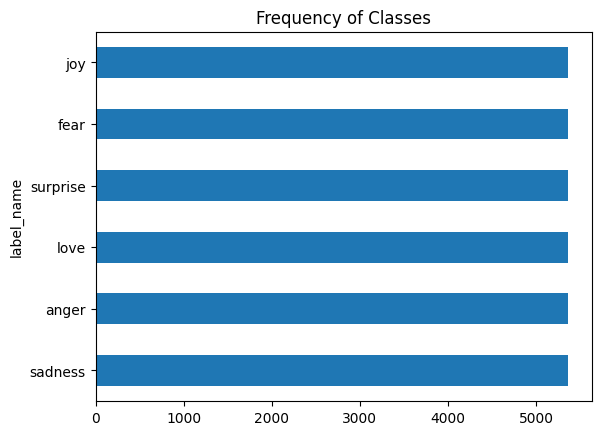

In [6]:
label_counts = df['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

<Axes: title={'center': 'Words per Tweet'}, xlabel='label_name'>

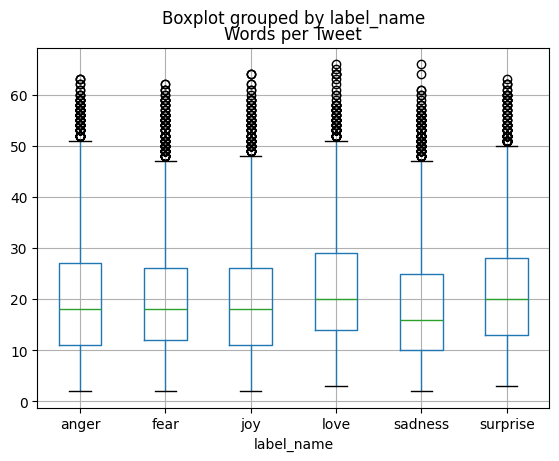

In [7]:
df['Words per Tweet'] = df['text'].str.split().apply(len)
df.boxplot("Words per Tweet", by="label_name")

## Text to Tokens Conversion
- Transformer models like BERT cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors.
- Tokenization is the step of breaking down a string into the atomic units used in the model

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


text = "I love machine learning! Tokenization is awesome!!"
encoded_text = tokenizer(text)
print(encoded_text)

In [9]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

## Data Loader and Train Test Split

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['label_name'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label_name'])

train.shape, test.shape, validation.shape

((22520, 5), (6434, 5), (3218, 5))

In [11]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {'train':Dataset.from_pandas(train, preserve_index=False),
     'test':Dataset.from_pandas(test, preserve_index=False),
     'validation': Dataset.from_pandas(validation, preserve_index=False)
     }

)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'is_synthetic', 'Words per Tweet'],
        num_rows: 22520
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'is_synthetic', 'Words per Tweet'],
        num_rows: 6434
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'is_synthetic', 'Words per Tweet'],
        num_rows: 3218
    })
})

## Tokenization of the Emotion/Sentiment Data

In [12]:
dataset['train'][0], dataset['train'][1]

({'text': 'with still feel jealous of my friends hella when their moms talk politely i them :(',
  'label': 3,
  'label_name': 'anger',
  'is_synthetic': 1,
  'Words per Tweet': 16},
 {'text': 'literally i scream every day and every night and no i hears and my face is starting to fall off and i feel anxious and frightened all the time and i don t think one sorta know what anything means anymore',
  'label': 4,
  'label_name': 'fear',
  'is_synthetic': 1,
  'Words per Tweet': 41})

In [13]:
def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 2007, 2145, 2514, 9981, 1997, 2026, 2814, 3109, 2050, 2043, 2037, 3566, 2015, 2831, 16954, 1045, 2068, 1024, 1006, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 6719, 1045, 6978, 2296, 2154, 1998, 2296, 2305, 1998, 2053, 1045, 14994, 1998, 2026, 2227, 2003, 3225, 2000, 2991, 2125, 1998, 1045, 2514, 11480, 1998, 10363, 2035, 1996, 2051, 1998, 1045, 2123, 1056, 2228, 2028, 4066, 2050, 2113, 2054, 2505, 2965, 4902, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

In [15]:
# label2id, id2label
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'anger': 3, 'fear': 4, 'sadness': 0, 'surprise': 5, 'love': 2, 'joy': 1},
 {3: 'anger', 4: 'fear', 0: 'sadness', 5: 'surprise', 2: 'love', 1: 'joy'})

## Model Building

In [16]:
from transformers import AutoModel
import torch

In [ ]:
model = AutoModel.from_pretrained(model_ckpt)

In [18]:
model.config.id2label
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Fine-Tuning Transformers

- `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs

- The first thing we need is a pretrained BERT model like the one we used in the feature-based approach.
- The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of AutoModel.
- The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model.

In [19]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [22]:
from transformers import TrainingArguments

batch_size = 64
training_dir = "bert_base_train_dir"

training_args = TrainingArguments( output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  num_train_epochs = 3,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  eval_strategy = 'epoch',
                                  disable_tqdm = False
)

In [ ]:
!pip install evaluate

In [ ]:
# Build compute metrics function
# !pip install evaluate
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)



In [26]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}


## Build Model and Trainer

In [27]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset = emotion_encoded['train'],
                  eval_dataset = emotion_encoded['validation'],
                  tokenizer = tokenizer)

/tmp/ipython-input-1591179924.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


In [28]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.173066,0.936296,0.935922
2,0.492100,0.118313,0.953387,0.953224
3,0.117200,0.116338,0.955873,0.955702


TrainOutput(global_step=1056, training_loss=0.29305345181262854, metrics={'train_runtime': 1022.2018, 'train_samples_per_second': 66.093, 'train_steps_per_second': 1.033, 'total_flos': 3020602839181920.0, 'train_loss': 0.29305345181262854, 'epoch': 3.0})

## Model Evaluation

In [29]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 0.13074690103530884,
 'test_accuracy': 0.953061858874728,
 'test_f1': 0.952901813636629,
 'test_runtime': 28.3533,
 'test_samples_per_second': 226.922,
 'test_steps_per_second': 3.562}

In [30]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1072
           1       0.95      0.94      0.94      1072
           2       0.96      0.96      0.96      1073
           3       0.94      0.98      0.96      1072
           4       0.97      0.91      0.94      1072
           5       0.93      0.99      0.96      1073

    accuracy                           0.95      6434
   macro avg       0.95      0.95      0.95      6434
weighted avg       0.95      0.95      0.95      6434



In [32]:
label2id

{'anger': 3, 'fear': 4, 'sadness': 0, 'surprise': 5, 'love': 2, 'joy': 1}

In [33]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

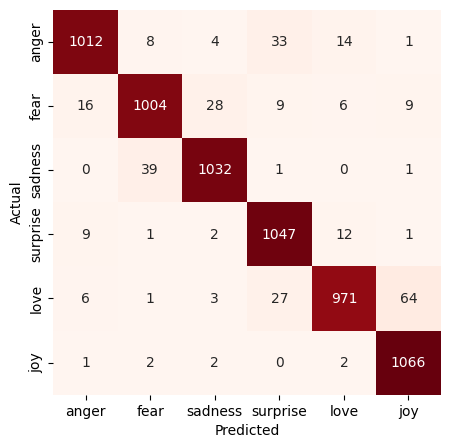

In [34]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## Build Prediction Function and Store Model

In [35]:
text = "I am super happy today. I got it done. Finally!!"

def get_prediction(text):
    input_encoded = tokenizer(text, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(**input_encoded)

    logits = outputs.logits

    pred = torch.argmax(logits, dim=1).item()
    return id2label[pred]

get_prediction(text)

'joy'

In [36]:
trainer.save_model("bert-base-uncased-sentiment-model")


In [38]:
text

'I am super happy today. I got it done. Finally!!'

In [39]:
# use pipeline for prediciton
from transformers import pipeline

classifier = pipeline('text-classification', model= 'bert-base-uncased-sentiment-model')

classifier([text, 'hello, how are you?', "love you", "i am feeling low"])

Device set to use cuda:0


[{'label': 'joy', 'score': 0.992010772228241},
 {'label': 'joy', 'score': 0.8941674828529358},
 {'label': 'love', 'score': 0.975590705871582},
 {'label': 'sadness', 'score': 0.9937352538108826}]

In [40]:
# 1. Zip the model folder
!zip -r bert_model.zip bert-base-uncased-sentiment-model

  adding: bert-base-uncased-sentiment-model/ (stored 0%)
  adding: bert-base-uncased-sentiment-model/special_tokens_map.json (deflated 42%)
  adding: bert-base-uncased-sentiment-model/tokenizer_config.json (deflated 75%)
  adding: bert-base-uncased-sentiment-model/training_args.bin (deflated 53%)
  adding: bert-base-uncased-sentiment-model/config.json (deflated 52%)
  adding: bert-base-uncased-sentiment-model/vocab.txt (deflated 53%)
  adding: bert-base-uncased-sentiment-model/model.safetensors (deflated 7%)
  adding: bert-base-uncased-sentiment-model/tokenizer.json (deflated 71%)


In [41]:
# 2. Download the zip file to your local machine
from google.colab import files
files.download('bert_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>